In [57]:
from glob import glob
import json
import multiprocessing as mp

import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch_geometric as pyg

import compopt
from compopt.constants import VOCAB
from compopt.utils import NumpyPreprocessor

DATA_DIR = '/data1/cbench-graphs'

In [10]:
graph_files = glob(f'{DATA_DIR}/nx/*.gexf')

In [11]:
graph_files

['/data1/cbench-graphs/nx/cbench-v1-qsort.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-tiffmedian.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-adpcm.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-bitcount.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-bzip2.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-lame.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-jpeg-c.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-tiff2bw.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-ghostscript.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-susan.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-gsm.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-sha.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-crc32.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-stringsearch.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-jpeg-d.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-blowfish.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-tiffdither.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-tiff2rgba.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-ispell.gexf',
 '/data1/cbench-graphs/nx/cbench-v1-

In [13]:
def _f(f):
    return nx.read_gexf(f, int)

with mp.Pool(len(graph_files)) as pool:
    graphs = pool.map(_f, graph_files)

In [14]:
graphs

In [15]:
graphs[0].number_of_nodes()

1351

In [16]:
nx.graph_clique_number(graphs[0].to_undirected())

3

In [17]:
nx.graph_number_of_cliques(graphs[0].to_undirected())

1691

In [18]:
text_dict = nx.get_node_attributes(graphs[0], 'text')
token_dict = {k: VOCAB[v] for k, v in text_dict.items()}

In [19]:
np.array(list(token_dict.values()))

array([4206, 1687, 1687, ...,  316, 7123,  676])

In [54]:
# pyg.utils.convert.from_networkx(
#     graphs[0],
#     group_node_attrs=,
#     group_edge_attrs= 
# )

ValueError: Not all nodes contain the same attributes

In [85]:
def plot_degree(g):
    plt.plot(sorted((d for n, d in g.degree()), reverse=True))
    plt.show()

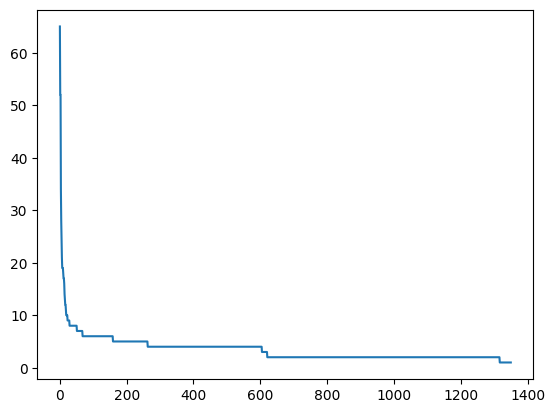

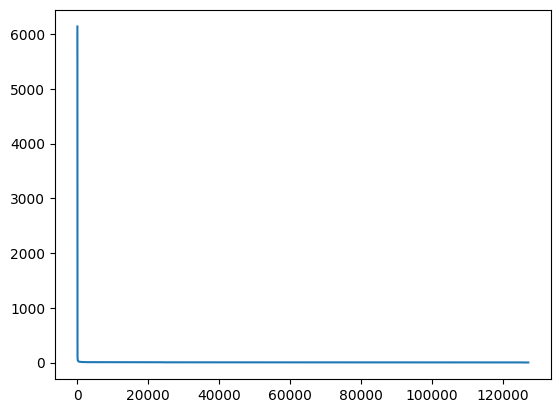

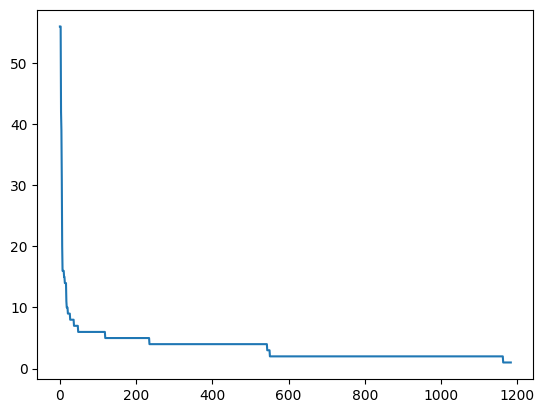

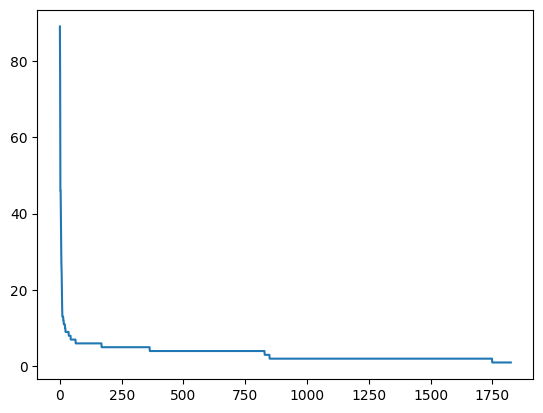

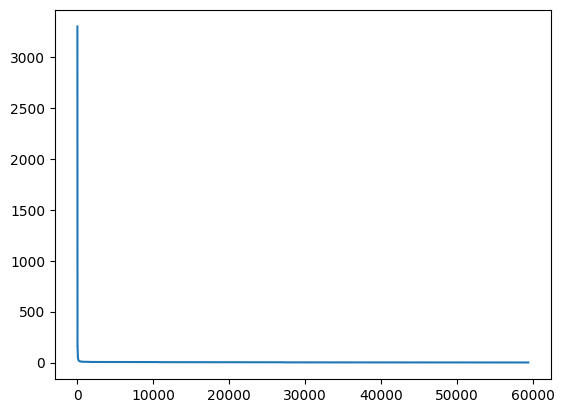

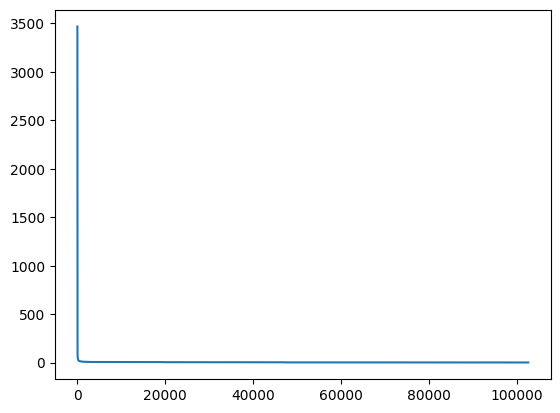

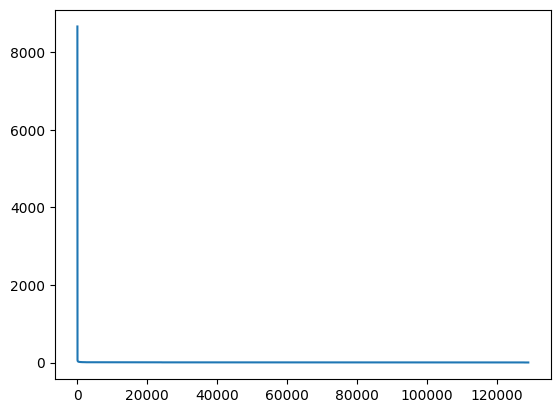

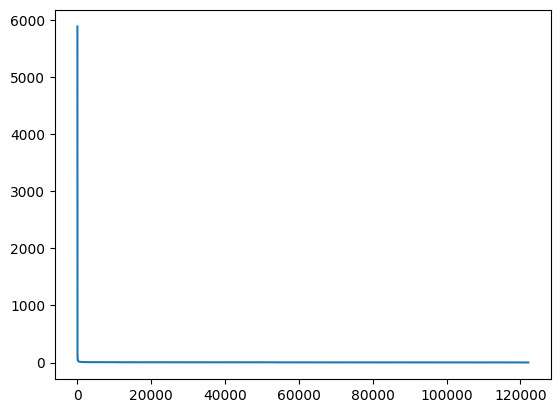

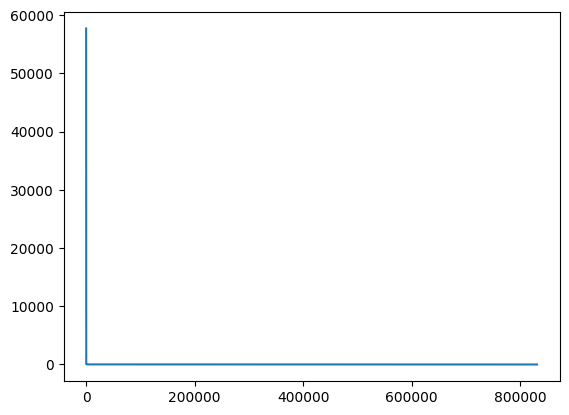

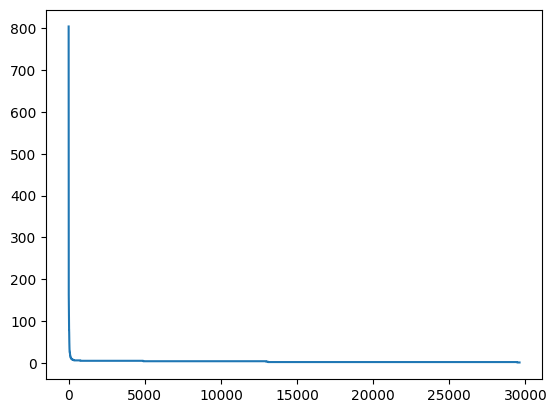

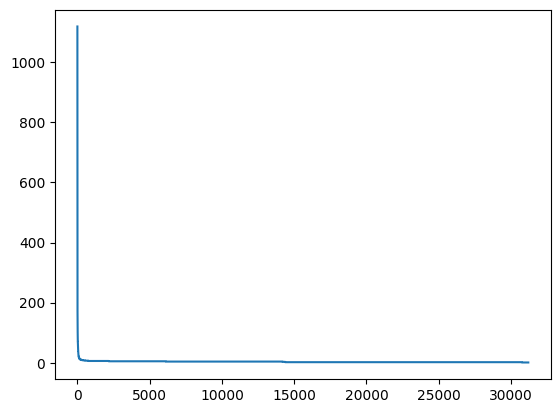

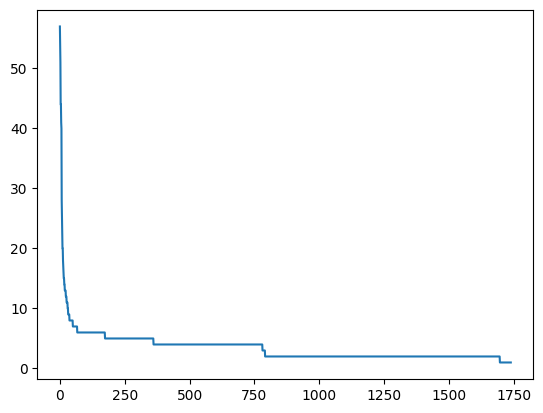

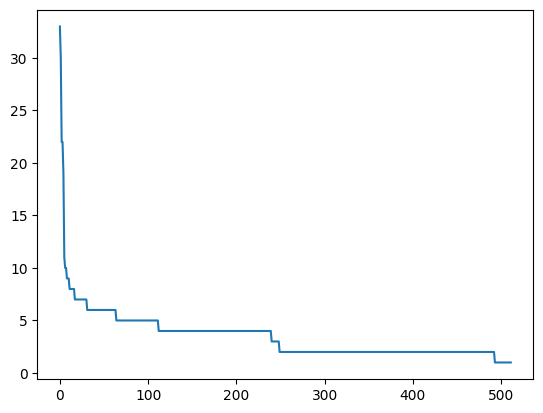

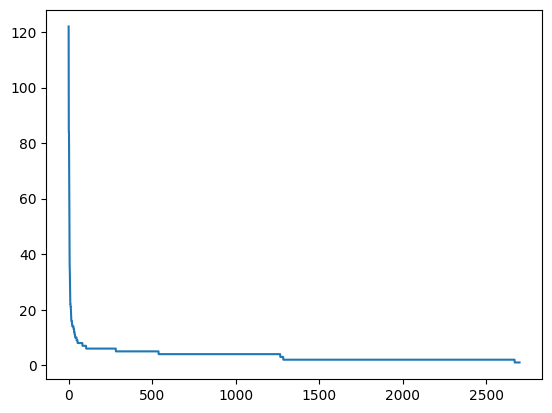

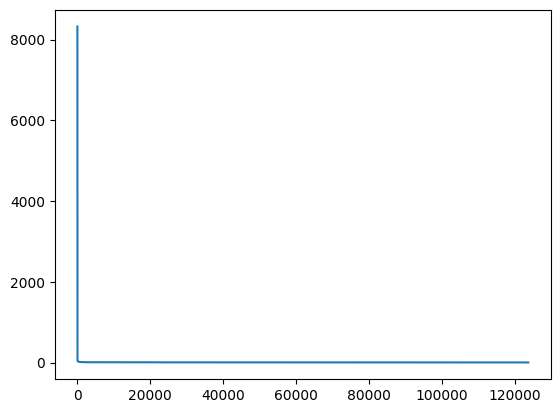

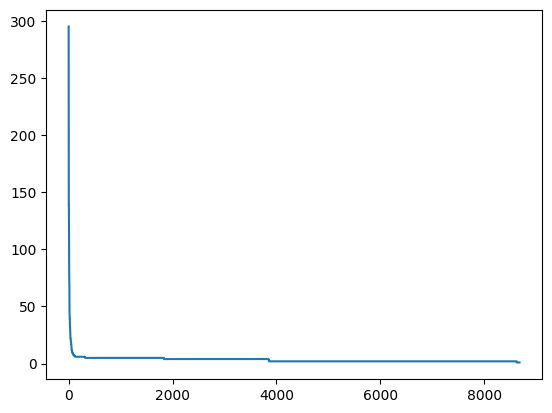

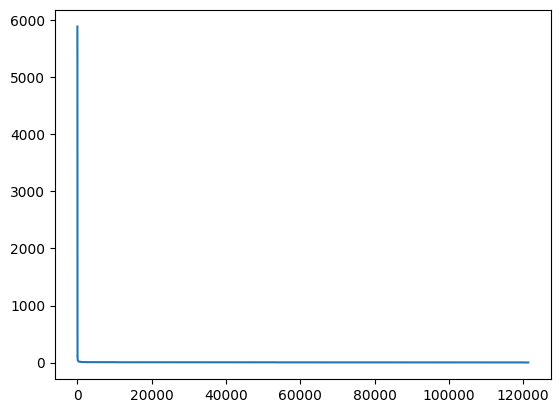

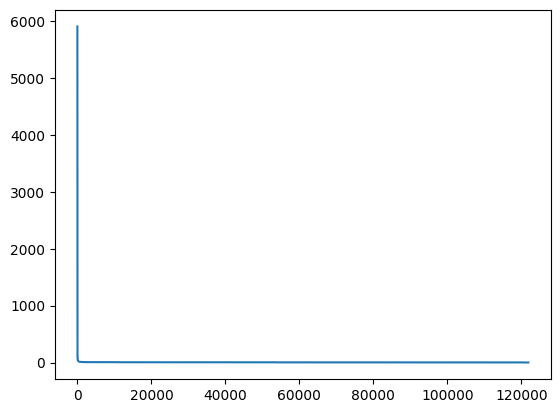

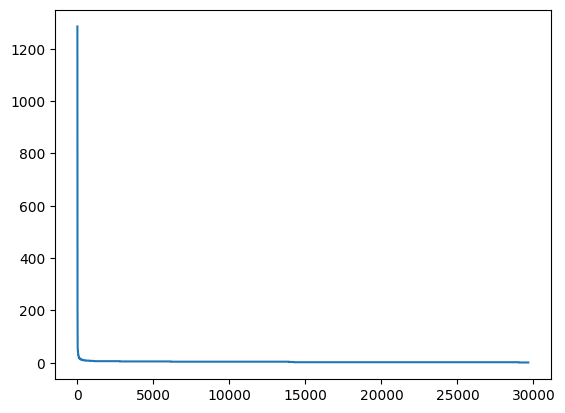

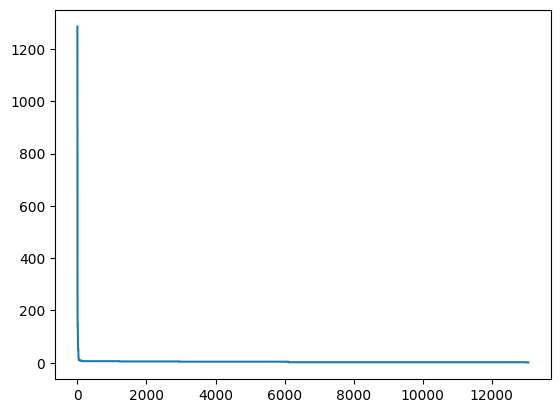

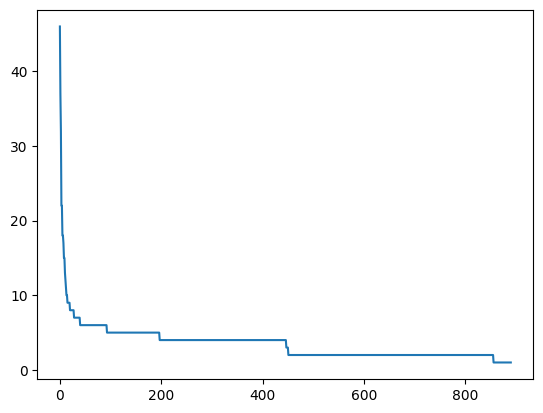

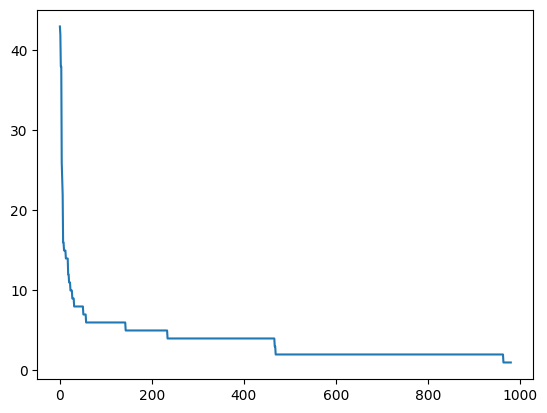

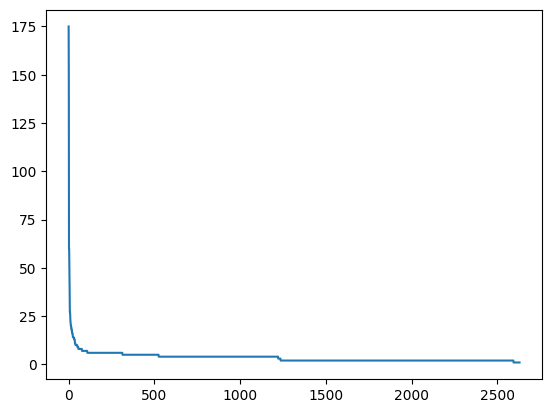

In [86]:
for g in graphs:
    plot_degree(g)

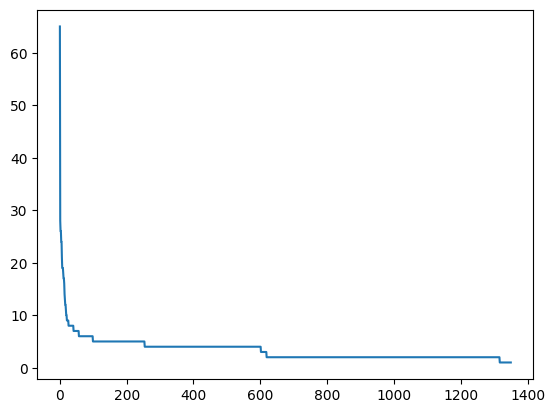

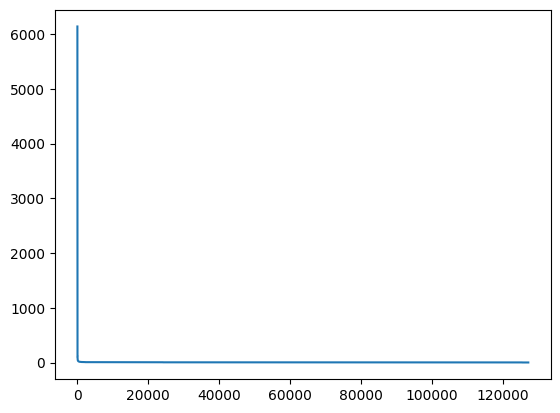

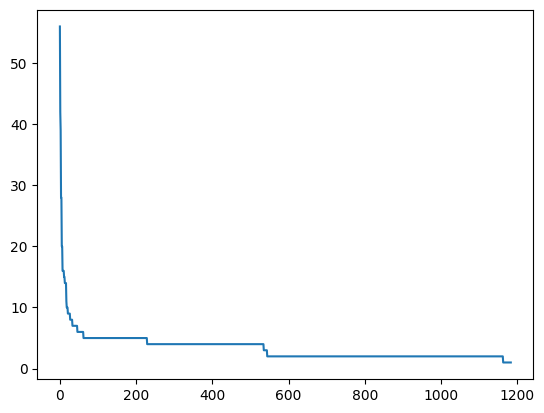

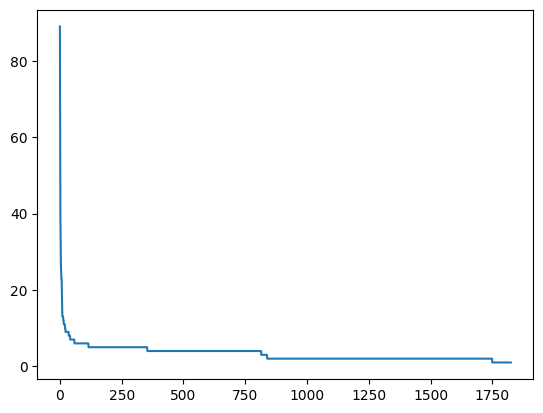

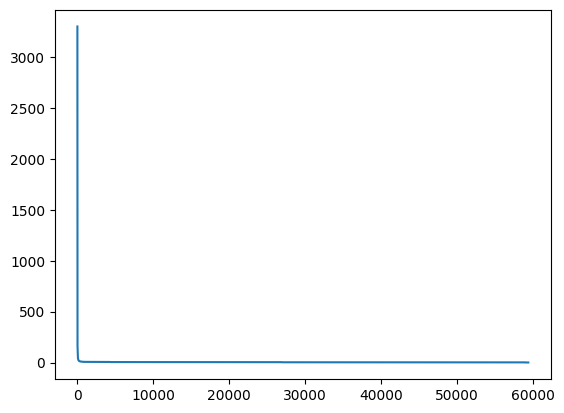

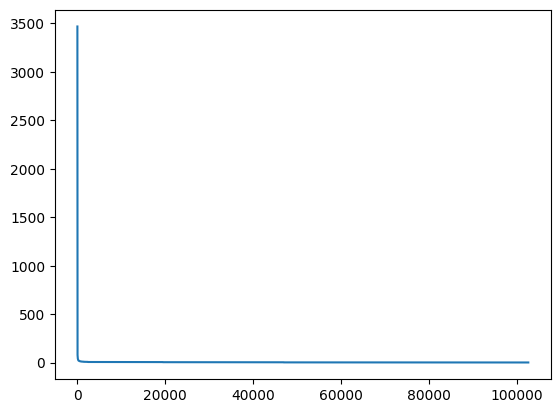

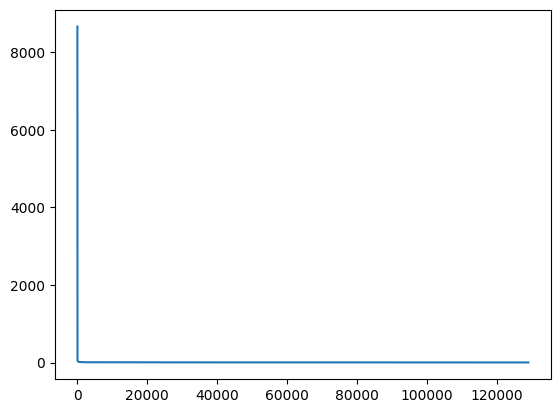

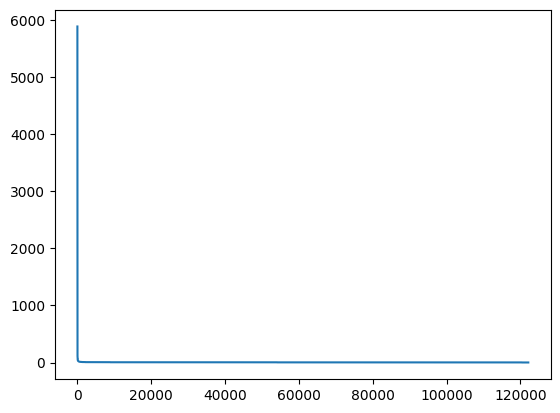

KeyboardInterrupt: 

In [88]:
# for g in graphs:
#     small = nx.smallworld.random_reference(g.to_undirected(), 5, connectivity=False)
#     plot_degree(small)

In [106]:
for f, g in zip(graph_files, graphs):
    print(f, nx.average_clustering(g))

/data1/cbench-graphs/nx/cbench-v1-qsort.gexf 0.13122395273611806
/data1/cbench-graphs/nx/cbench-v1-tiffmedian.gexf 0.16630272662354031
/data1/cbench-graphs/nx/cbench-v1-adpcm.gexf 0.14615117690775578
/data1/cbench-graphs/nx/cbench-v1-bitcount.gexf 0.1664225469735197
/data1/cbench-graphs/nx/cbench-v1-bzip2.gexf 0.18207538259967818
/data1/cbench-graphs/nx/cbench-v1-lame.gexf 0.17010434649125783
/data1/cbench-graphs/nx/cbench-v1-jpeg-c.gexf 0.17883524008742224
/data1/cbench-graphs/nx/cbench-v1-tiff2bw.gexf 0.16543068048143927


KeyboardInterrupt: 

In [20]:
processer = NumpyPreprocessor(VOCAB)

In [33]:
x, edge_index, edge_attr = processer.process(graphs[0])
data = pyg.data.Data(
    torch.FloatTensor(x),
    torch.LongTensor(edge_index),
    torch.FloatTensor(edge_attr)
)

In [80]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = pyg.nn.GATv2Conv(7699, 128, 4, edge_dim=3)
        self.c2 = pyg.nn.GATv2Conv(128 * 4, 128, 4, edge_dim=3)
        self.mu = torch.nn.LazyLinear(128)
        self.sigma = torch.nn.LazyLinear(128)
    
    def forward(self, data):
        x = self.c1(data.x, data.edge_index, data.edge_attr)
        x = F.relu(x)
        x = self.c2(x, data.edge_index, data.edge_attr)
        x = F.relu(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        
        return mu, sigma

In [87]:
ae = pyg.nn.VGAE(Encoder()).to('cuda:0')

In [88]:
optim = torch.optim.AdamW(ae.parameters())

In [89]:
ae.encode(data)

tensor([[-0.6400, -1.3142, -0.3528,  ...,  0.3609,  0.1578, -1.0542],
        [ 1.5996, -2.2276, -0.0079,  ..., -1.3181,  1.5733,  0.3058],
        [ 1.1598, -1.5520, -1.1620,  ...,  0.7064, -0.3636,  1.0973],
        ...,
        [-0.3478, -0.7760, -0.8336,  ...,  1.3070,  0.5139, -2.4016],
        [ 0.1094,  1.3621, -1.2663,  ...,  0.9752, -1.0099, -1.2952],
        [-0.3343,  0.2263, -0.0916,  ..., -0.3339,  0.9688, -0.8713]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
for _ in (10):
    for g in graphs:
        x, edge_index, edge_attr = processer.process(g)
        data = pyg.data.Data(
            torch.FloatTensor(x),
            torch.LongTensor(edge_index),
            torch.FloatTensor(edge_attr)
        ).to('cuda:0')
        ae.encode(data)

        optim.zero_grad()

        loss = ae.kl_loss()
        loss.backward()

        optim.step()

        print(loss)

tensor(0.1360, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0676, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0293, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0144, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0134, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0118, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0087, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<MulBackward0>)
